<a href="https://colab.research.google.com/github/khairul746/portfolio/blob/main/Rock_Paper_Scissor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock, Paper, Scissor Recognition
<body>
Khairullah Ilyas<br>
Kab.Agam, Sumatera Barat
</body>

### Import Library

In [1]:
import tensorflow as tf
import zipfile
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
if tf.test.gpu_device_name():
    print("GPU device found")
else:
    print("No GPU device found")

GPU device found


## Extract Data

In [3]:
url = 'https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip'
file_path = 'rockpaperscissors.zip'

# Download zip file
response = requests.get(url)
with open(file_path, 'wb') as f:
    f.write(response.content)

In [4]:
# Extract zip file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
# Labelling Classes
labels = ['paper','scissors','rock']
nb = len(labels) # Number of classes

In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def input_target_split(train_dir,labels):
    dataset = []
    count = 0
    for label in labels:
        folder = os.path.join(train_dir,label)
        for image in os.listdir(folder):
            img=load_img(os.path.join(folder,image), target_size=(150,150))
            img=img_to_array(img)
            img=img/255.0
            dataset.append((img,count))
        print(f'\rCompleted: {label}',end='')
        count+=1
    random.shuffle(dataset)
    X, y = zip(*dataset)

    return np.array(X),np.array(y)

In [7]:
# Convert image data to arrays and image label to numbers
X, y = input_target_split('rockpaperscissors',labels)

Completed: rock

## Check the Data by Visualization

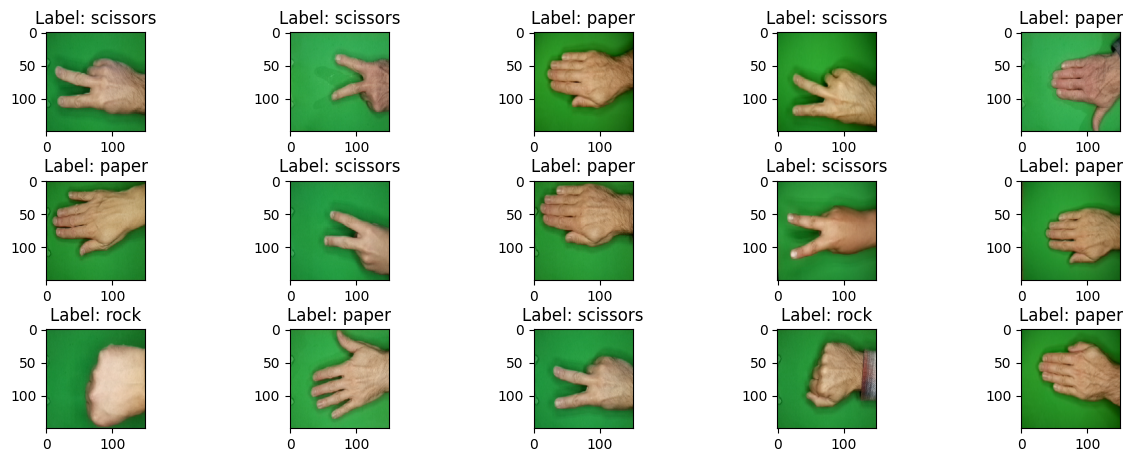

In [8]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(X[i])
    plt.title(f'Label: {labels[y[i]]}')

## Split Data into Train Set and Test Set

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42) # 40% of dataset are Test Set

In [10]:
# One-Hot Encoding
y_train = np.eye(nb)[y_train]
y_test = np.eye(nb)[y_test]

## Image Augmentation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Augmentation for Train Data
train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    )

test_datagen = ImageDataGenerator()

train_datagen.fit(X_train)
test_datagen.fit(X_test)

## Define the model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

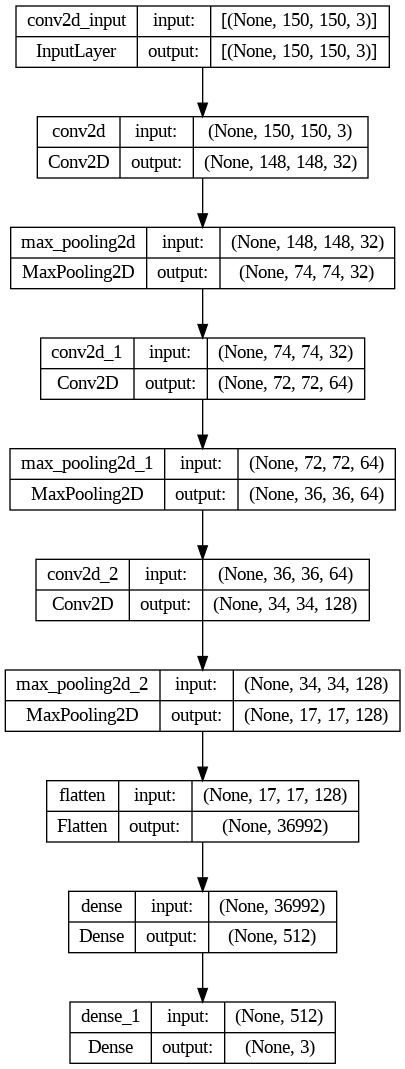

In [13]:
from keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
Image(filename='model_plot.png')


## Compile and Train the Model

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# Define Callback Class
from keras.callbacks import Callback

class StopTrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.99:
            print("\nReached 99% accuracy. Stopping training...")
            self.model.stop_training = True

In [16]:
hist = model.fit_generator(train_datagen.flow(X_train,y_train,batch_size=32),
                                        validation_data=test_datagen.flow(X_test,y_test,batch_size=50),
                                        epochs=30,
                                        callbacks=[StopTrainingCallback()]
                           )

<ipython-input-16-4be7a92bb4df>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_datagen.flow(X_train,y_train,batch_size=32),


Epoch 1/30
41/41 [==============================] - 20s 290ms/step - loss: 1.1423 - accuracy: 0.3941 - val_loss: 1.0763 - val_accuracy: 0.3870
Epoch 2/30
41/41 [==============================] - 7s 167ms/step - loss: 0.9624 - accuracy: 0.5297 - val_loss: 0.7539 - val_accuracy: 0.6735
Epoch 3/30
41/41 [==============================] - 7s 168ms/step - loss: 0.8785 - accuracy: 0.6189 - val_loss: 0.4611 - val_accuracy: 0.9201
Epoch 4/30
41/41 [==============================] - 7s 172ms/step - loss: 0.5566 - accuracy: 0.7896 - val_loss: 0.1676 - val_accuracy: 0.9612
Epoch 5/30
41/41 [==============================] - 8s 192ms/step - loss: 0.3897 - accuracy: 0.8544 - val_loss: 0.2159 - val_accuracy: 0.9372
Epoch 6/30
41/41 [==============================] - 8s 192ms/step - loss: 0.3338 - accuracy: 0.8880 - val_loss: 0.1503 - val_accuracy: 0.9589
Epoch 7/30
41/41 [==============================] - 7s 169ms/step - loss: 0.2784 - accuracy: 0.9055 - val_loss: 0.1287 - val_accuracy: 0.9669
Epoch

In [43]:
# Clear session
# tf.keras.backend.clear_session()

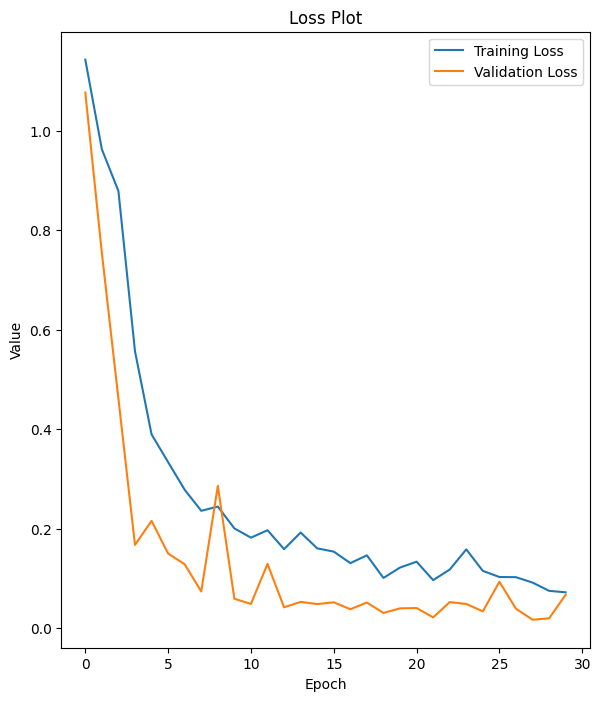

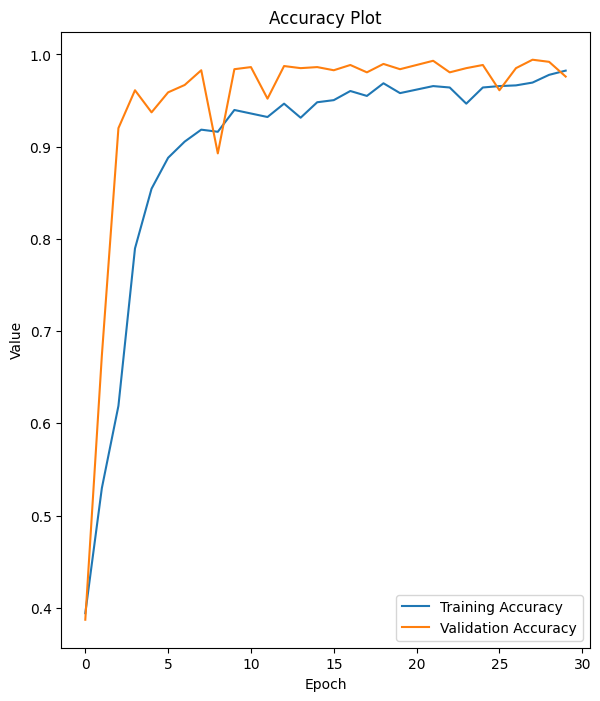

In [17]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(20)

#loss train & validation
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

#accuracy train & validation
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

Saving WhatsApp_Image_2024-05-06_at_16.11.57_5fe5cdf7-removebg-preview.png to WhatsApp_Image_2024-05-06_at_16.11.57_5fe5cdf7-removebg-preview (2).png
1/1 [==============================] - 0s 280ms/step
[[1. 0. 0.]]
WhatsApp_Image_2024-05-06_at_16.11.57_5fe5cdf7-removebg-preview (2).png
paper


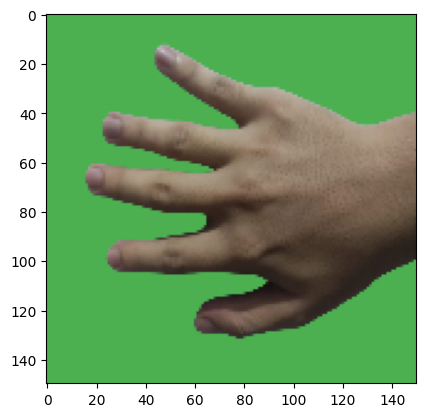

In [18]:
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg

uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size =(150,150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=50)
    print(classes)
    print(fn)
    if classes[0][0]==1:
        print('paper')
    elif classes[0][1]==1:
        print('scissor')
    else:
        print('rock')

## Save the Model

In [19]:
model.save('trained_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load the Model

In [20]:
from keras.models import load_model

CNN_model = load_model('trained_model.h5')

In [21]:
y_pred = CNN_model.predict(X_test)
pred = np.argmax(y_pred,axis=1)
ground = np.argmax(y_test,axis=1)

28/28 [==============================] - 1s 17ms/step


## Model Report

In [22]:
from sklearn.metrics import classification_report

print(classification_report(ground,pred,target_names = labels))

              precision    recall  f1-score   support

       paper       0.93      1.00      0.96       283
    scissors       1.00      0.97      0.98       303
        rock       1.00      0.96      0.98       290

    accuracy                           0.98       876
   macro avg       0.98      0.98      0.98       876
weighted avg       0.98      0.98      0.98       876

